# Climate Analysis Vancouver

### EDA

- Import necessary libraries for data handling and visualization.

In [42]:
# Importing all necessary libraries for data loading, handling, analysis, and visualization

# Data handling and manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")  # Set Seaborn style for nicer visuals

# Time-series modeling and forecasting
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for time-series

# Prophet library import is conditional since it may not be installed in this environment
from prophet import Prophet

# Model evaluation
from sklearn.metrics import mean_squared_error  # To evaluate model performance

# Statistical analysis (if needed for additional tests)
from scipy import stats

# Date handling
from datetime import datetime

# Set default figure size for plots to ensure consistency
plt.rcParams["figure.figsize"] = (12, 6)  # Default figure size
plt.rcParams["axes.titlesize"] = 16       # Title font size
plt.rcParams["axes.labelsize"] = 14       # Axis label font size

# Verification of library import success
"All necessary libraries imported successfully."

'All necessary libraries imported successfully.'

- Load the dataset using the specified file path.
- Display the first few rows to get an overview of the dataset structure.

In [43]:
# Load the dataset
data_file_path = '/Users/shariq/Desktop/Project/data/weatherstats_vancouver_normal_monthly.csv'
data = pd.read_csv(data_file_path)

# Inspect the first few rows
data.head()

,date,max_dew_point_v,max_dew_point_s,max_dew_point_c,max_dew_point_d,max_relative_humidity_v,max_relative_humidity_s,max_relative_humidity_c,max_relative_humidity_d,max_temperature_v,...,snow_c,snow_d,snow_on_ground_v,snow_on_ground_s,snow_on_ground_c,snow_on_ground_d,solar_radiation_v,solar_radiation_s,solar_radiation_c,solar_radiation_d
0,2024-11-01,6.20,1.46,30.0,1994-11-01 2023-11-01,94.32,3.60,30.0,1994-11-01 2023-11-01,9.37,...,30,1994-11-01 2023-11-01,0.3,0.72,24.0,1994-11-01 2022-11-01,NaN,NaN,NaN,NaN
1,2024-10-01,9.68,1.22,30.0,1994-10-01 2023-10-01,94.03,4.02,30.0,1994-10-01 2023-10-01,13.60,...,30,1994-10-01 2023-10-01,0.0,0.00,23.0,1994-10-01 2016-10-01,NaN,NaN,NaN,NaN
2,2024-09-01,13.28,1.12,30.0,1994-09-01 2023-09-01,92.44,3.82,30.0,1994-09-01 2023-09-01,19.08,...,30,1994-09-01 2023-09-01,0.0,0.00,21.0,1994-09-01 2016-09-01,NaN,NaN,NaN,NaN
3,2024-08-01,15.19,1.25,30.0,1994-08-01 2023-08-01,89.05,4.54,30.0,1994-08-01 2023-08-01,22.57,...,30,1994-08-01 2023-08-01,0.0,0.00,22.0,1994-08-01 2016-08-01,NaN,NaN,NaN,NaN
4,2024-07-01,14.78,1.11,30.0,1994-07-01 2023-07-01,86.64,4.48,30.0,1994-07-01 2023-07-01,22.67,...,30,1994-07-01 2023-07-01,0.0,0.00,23.0,1994-07-01 2017-07-01,NaN,NaN,NaN,NaN


**Code Explanation**:
- Convert the `date` column to datetime format for easier time-series manipulation.
- Calculate `avg_temperature_v` as the average of `max_temperature_v` and `min_temperature_v`.
- Select relevant columns (`date`, `avg_temperature_v`, `precipitation_v`), and set `date` as the index.

In [76]:
# # Convert date column to datetime and calculate average temperature
# data['date'] = pd.to_datetime(data['date'], errors='coerce')
# data['avg_temperature_v'] = (data['max_temperature_v'] + data['min_temperature_v']) / 2

# # Select relevant columns and drop rows with missing values
# cleaned_data = data[['date', 'avg_temperature_v', 'precipitation_v']].dropna()
# cleaned_data.set_index('date', inplace=True)

# # Confirm the cleaned data structure
# cleaned_data.info()
# cleaned_data.describe()

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Convert all relevant columns to numeric to handle any non-numeric values
for col in data.columns:
    if col.startswith(('min_', 'max_', 'temperature', 'humidity', 'precipitation', 'wind_speed')):
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculate averages for min/max pairs and mark them for dropping
columns_to_drop = []
for col in data.columns:
    if col.startswith('min_') and col.replace('min_', 'max_') in data.columns:
        # Define the base name by removing the 'min_' prefix
        base_name = col.replace('min_', '')
        # Calculate the average and create a new column with an 'avg_' prefix
        data[f'avg_{base_name}'] = (data[col] + data[f'max_{base_name}']) / 2
        # Mark the original min/max columns for dropping
        columns_to_drop.extend([col, f'max_{base_name}'])

# Drop temperature min/max columns after averaging, if they exist
if 'max_temperature_v' in data.columns and 'min_temperature_v' in data.columns:
    data['avg_temperature_v'] = (data['max_temperature_v'] + data['min_temperature_v']) / 2
    columns_to_drop.extend(['max_temperature_v', 'min_temperature_v'])

# Drop all columns ending with '_c' (e.g., counts or other metadata)
columns_to_drop.extend([col for col in data.columns if col.endswith('_c')])

# Drop the identified columns from the dataset
data.drop(columns=columns_to_drop, inplace=True)

# Drop rows with missing values only for essential columns (date, avg_temperature_v, precipitation_v)
# We retain all other variables at this stage for correlation analysis
cleaned_data = data.dropna(subset=['date', 'avg_temperature_v', 'precipitation_v']).set_index('date')

# Confirm structure of cleaned data
cleaned_data.info()
cleaned_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2024-11-01 to 1941-08-01
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   precipitation_v          1000 non-null   float64
 1   precipitation_s          1000 non-null   float64
 2   precipitation_d          0 non-null      float64
 3   rain_v                   1000 non-null   float64
 4   rain_s                   1000 non-null   float64
 5   rain_d                   1000 non-null   object 
 6   snow_v                   1000 non-null   float64
 7   snow_s                   1000 non-null   float64
 8   snow_d                   1000 non-null   object 
 9   snow_on_ground_v         827 non-null    float64
 10  snow_on_ground_s         827 non-null    float64
 11  snow_on_ground_d         827 non-null    object 
 12  solar_radiation_v        0 non-null      float64
 13  solar_radiation_s        0 non-null      float64
 14  solar_

,precipitation_v,precipitation_s,precipitation_d,rain_v,rain_s,snow_v,snow_s,snow_on_ground_v,snow_on_ground_s,solar_radiation_v,...,avg_dew_point_s,avg_dew_point_d,avg_relative_humidity_v,avg_relative_humidity_s,avg_relative_humidity_d,avg_temperature_s,avg_temperature_d,avg_wind_speed_v,avg_wind_speed_s,avg_wind_speed_d
count,1000.000000,1000.000000,0.0,1000.00000,1000.000000,1000.000000,1000.000000,827.000000,827.000000,0.0,...,851.000000,0.0,851.000000,851.000000,0.0,1000.000000,0.0,851.000000,851.000000,0.0
mean,92.818390,39.332480,NaN,88.80240,39.959220,3.641430,5.447260,0.277872,0.560133,NaN,...,1.415887,NaN,78.748543,3.301234,NaN,1.233850,NaN,12.963290,1.837891,NaN
std,48.230084,14.150806,NaN,44.43504,14.716424,6.017777,8.018831,0.517497,0.990203,NaN,...,0.550799,NaN,4.732179,0.856743,NaN,0.450074,NaN,1.113735,0.568728,NaN
min,20.160000,7.950000,NaN,20.16000,6.200000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,NaN,71.095000,0.000000,NaN,0.650000,NaN,10.825000,0.000000,NaN
25%,49.650000,27.467500,NaN,49.65000,27.410000,0.000000,0.000000,0.000000,0.000000,NaN,...,1.050000,NaN,74.087500,2.867500,NaN,0.950000,NaN,12.047500,1.485000,NaN
50%,87.880000,36.350000,NaN,85.69000,36.315000,0.070000,0.360000,0.000000,0.000000,NaN,...,1.230000,NaN,78.180000,3.405000,NaN,1.085000,NaN,12.970000,1.785000,NaN
75%,125.795000,51.917500,NaN,120.47000,52.882500,5.415000,10.400000,0.300000,0.760000,NaN,...,1.772500,NaN,83.507500,3.830000,NaN,1.480000,NaN,13.795000,2.265000,NaN
max,214.670000,73.370000,NaN,208.68000,77.240000,28.670000,29.640000,2.500000,4.190000,NaN,...,3.250000,NaN,88.790000,5.160000,NaN,3.490000,NaN,16.920000,3.245000,NaN


**Code Explanation**:
- Plot the average temperature over time to observe general trends and seasonal fluctuations.
- Plot total monthly precipitation to identify any seasonal or long-term changes in precipitation.

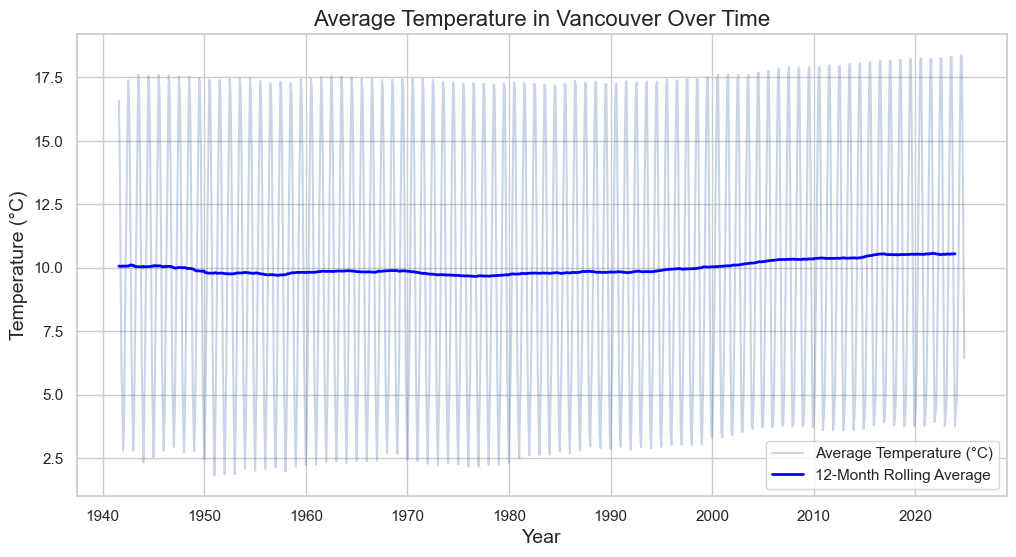

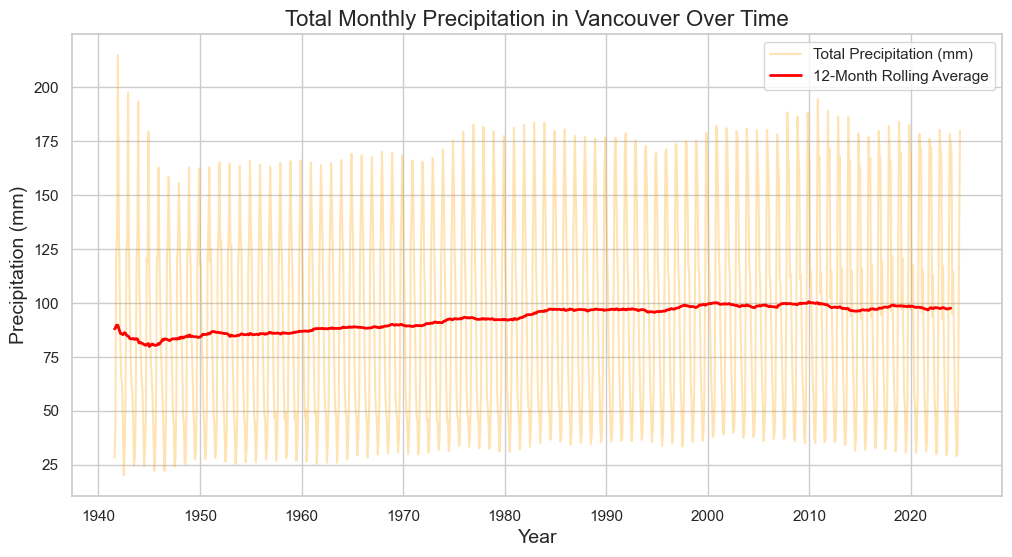

In [77]:
# Plot average temperature with smoothing
plt.figure(figsize=(12, 6))
plt.plot(cleaned_data['avg_temperature_v'], label='Average Temperature (°C)', alpha=0.3)
plt.plot(cleaned_data['avg_temperature_v'].rolling(window=12).mean(), label='12-Month Rolling Average', color='blue', linewidth=2)
plt.title('Average Temperature in Vancouver Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plot total precipitation with smoothing
plt.figure(figsize=(12, 6))
plt.plot(cleaned_data['precipitation_v'], label='Total Precipitation (mm)', color='orange', alpha=0.3)
plt.plot(cleaned_data['precipitation_v'].rolling(window=12).mean(), label='12-Month Rolling Average', color='red', linewidth=2)
plt.title('Total Monthly Precipitation in Vancouver Over Time')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

**Code Explanation**:
- Fit an ARIMA model to forecast average temperature values.
- Display the forecast with confidence intervals.

In [46]:
# # Set frequency to monthly and sort the index to ensure it's monotonic
# cleaned_data = cleaned_data.asfreq('MS').sort_index()

# # Now try the ARIMA model again
# from statsmodels.tsa.arima.model import ARIMA

# # ARIMA model for temperature forecasting
# temp_model = ARIMA(cleaned_data['avg_temperature_v'], order=(1, 1, 1))
# temp_fit = temp_model.fit()
# temp_forecast = temp_fit.get_forecast(steps=12)
# temp_forecast_ci = temp_forecast.conf_int()

# # Plot forecast
# plt.figure(figsize=(12, 6))
# plt.plot(cleaned_data['avg_temperature_v'], label='Observed')
# plt.plot(temp_forecast.predicted_mean, label='Forecast', color='red')
# plt.fill_between(temp_forecast_ci.index, 
#                  temp_forecast_ci.iloc[:, 0], 
#                  temp_forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
# plt.title('Average Temperature Forecast')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.legend()
# plt.show()


Prepare Data for Prophet
- Create a new DataFrame with only the date and average temperature columns.
- Rename columns to 'ds' for the date and 'y' for the temperature values, as required by Prophet.

In [57]:
# # Step 1: Prepare data for Prophet
# prophet_data = cleaned_data[['avg_temperature_v']].reset_index()
# prophet_data.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for the value

Initialize and Fit the Prophet Model
- Set up an instance of the Prophet model.
- Fit the Prophet model to the historical temperature data to capture trends and seasonality.


Generate Future Dates for Forecasting
- Create a future date range (e.g., for the next 12 months) to extend the data.
- Use Prophet to predict temperature values for these future dates.

  
Plot the Forecast
- Visualize the forecasted temperature values along with the observed data.
- Include confidence intervals to show the uncertainty range in the forecast.

In [58]:
# # Step 2: Initialize and fit the Prophet model
# prophet_model = Prophet()
# prophet_model.fit(prophet_data)

# # Step 3: Make a DataFrame for future dates and predict future values
# future = prophet_model.make_future_dataframe(periods=12, freq='M')  # Forecasting the next 12 months
# forecast = prophet_model.predict(future)

# # Step 4: Plot the forecast
# fig = prophet_model.plot(forecast)
# plt.title('Average Temperature Forecast (Prophet)')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.show()

In [59]:
# # Step 1: Limit the historical data to recent years (e.g., from 2000 onward)
# recent_data = prophet_data[prophet_data['ds'] >= '2000-01-01']

# # Step 2: Plot recent historical data and forecast
# plt.figure(figsize=(12, 6))
# plt.plot(recent_data['ds'], recent_data['y'], label='Observed', color='blue', alpha=0.6)

# # Step 3: Plot the forecasted values
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

# # Add labels and legend
# plt.title('Average Temperature Forecast (Prophet)')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.legend()
# plt.show()


In [60]:
# # Limit the historical data for plotting to the last 20 years (from 2000 onward)
# recent_data = prophet_data[prophet_data['ds'] >= '2000-01-01']  # Adjust start year as needed

# # Plot recent historical data and the forecast
# plt.figure(figsize=(12, 6))

# # Plot the observed data (last 20 years)
# plt.plot(recent_data['ds'], recent_data['y'], label='Observed', color='blue', alpha=0.6, linewidth=1)

# # Plot the forecasted values and confidence intervals
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linewidth=1)
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

# # Customize the plot
# plt.title('Average Temperature Forecast (Prophet)')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.legend()
# plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2030-01-01')])  # Restrict x-axis to recent years and forecast period
# plt.show()


## Phase 2

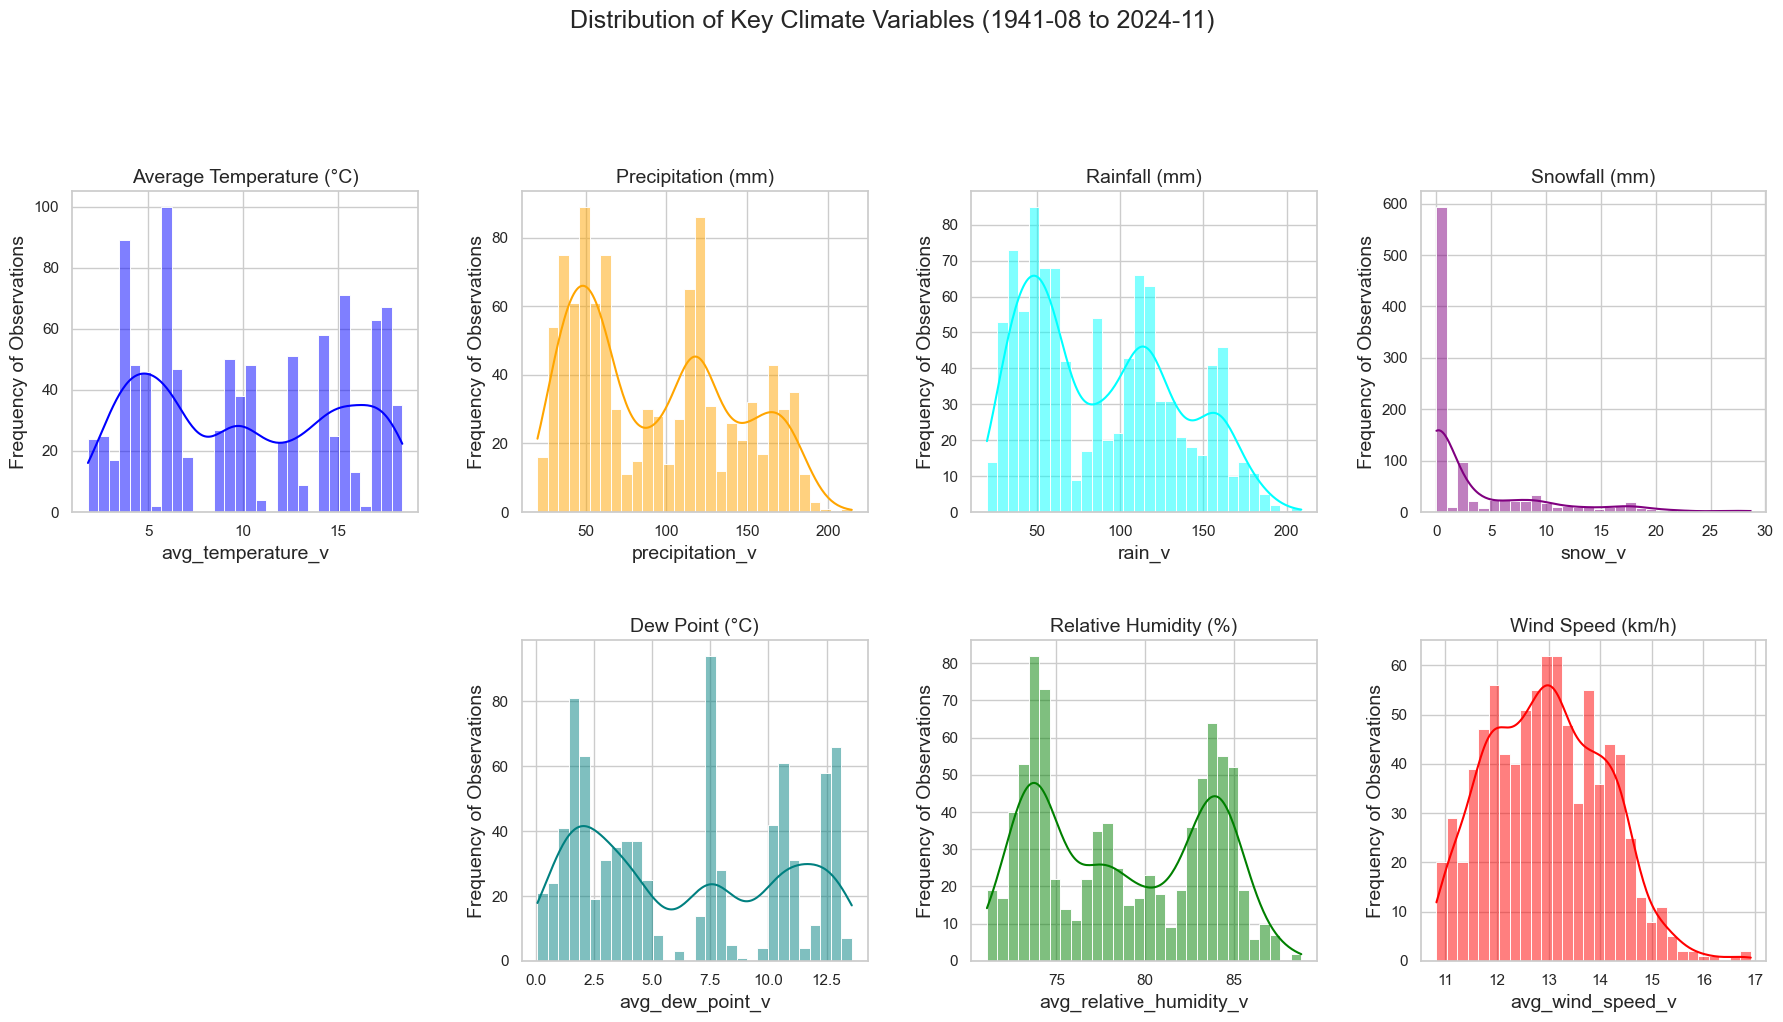

In [114]:
# Extract date range from the dataset, formatted as "YYYY-MM"
date_min = cleaned_data.index.min().strftime('%Y-%m')
date_max = cleaned_data.index.max().strftime('%Y-%m')
date_range = f" ({date_min} to {date_max})"

# Set up the figure for subplots with a 2x4 grid to give each plot more space
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle(f'Distribution of Key Climate Variables{date_range}', fontsize=18, y=1.05)

# Histogram for Average Temperature
sns.histplot(cleaned_data['avg_temperature_v'].dropna(), bins=30, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title(f"Average Temperature (°C)", fontsize=14)
axes[0, 0].set_ylabel("Frequency of Observations")

# Histogram for Precipitation
sns.histplot(cleaned_data['precipitation_v'].dropna(), bins=30, kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title(f"Precipitation (mm)", fontsize=14)
axes[0, 1].set_ylabel("Frequency of Observations")

# Histogram for Rainfall
if 'rain_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['rain_v'].dropna(), bins=30, kde=True, ax=axes[0, 2], color='cyan')
    axes[0, 2].set_title(f"Rainfall (mm)", fontsize=14)
    axes[0, 2].set_ylabel("Frequency of Observations")

# Histogram for Snowfall
if 'snow_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['snow_v'].dropna(), bins=30, kde=True, ax=axes[0, 3], color='purple')
    axes[0, 3].set_title(f"Snowfall (mm)", fontsize=14)
    axes[0, 3].set_ylabel("Frequency of Observations")

# Histogram for Solar Radiation
if 'solar_radiation_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['solar_radiation_v'].dropna(), bins=30, kde=True, ax=axes[1, 0], color='gold')
    axes[1, 0].set_title(f"Solar Radiation (MJ/m²)", fontsize=14)
    axes[1, 0].set_ylabel("Frequency of Observations")

# Histogram for Dew Point
if 'avg_dew_point_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['avg_dew_point_v'].dropna(), bins=30, kde=True, ax=axes[1, 1], color='teal')
    axes[1, 1].set_title(f"Dew Point (°C)", fontsize=14)
    axes[1, 1].set_ylabel("Frequency of Observations")

# Histogram for Relative Humidity
if 'avg_relative_humidity_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['avg_relative_humidity_v'].dropna(), bins=30, kde=True, ax=axes[1, 2], color='green')
    axes[1, 2].set_title(f"Relative Humidity (%)", fontsize=14)
    axes[1, 2].set_ylabel("Frequency of Observations")

# Histogram for Wind Speed
if 'avg_wind_speed_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['avg_wind_speed_v'].dropna(), bins=30, kde=True, ax=axes[1, 3], color='red')
    axes[1, 3].set_title(f"Wind Speed (km/h)", fontsize=14)
    axes[1, 3].set_ylabel("Frequency of Observations")

# Hide any empty subplots (if fewer than 8 variables)
for i in range(2):
    for j in range(4):
        if not axes[i][j].has_data():
            axes[i][j].set_visible(False)

# Adjust layout to improve spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to fit the overall title
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add spacing between plots
plt.show()


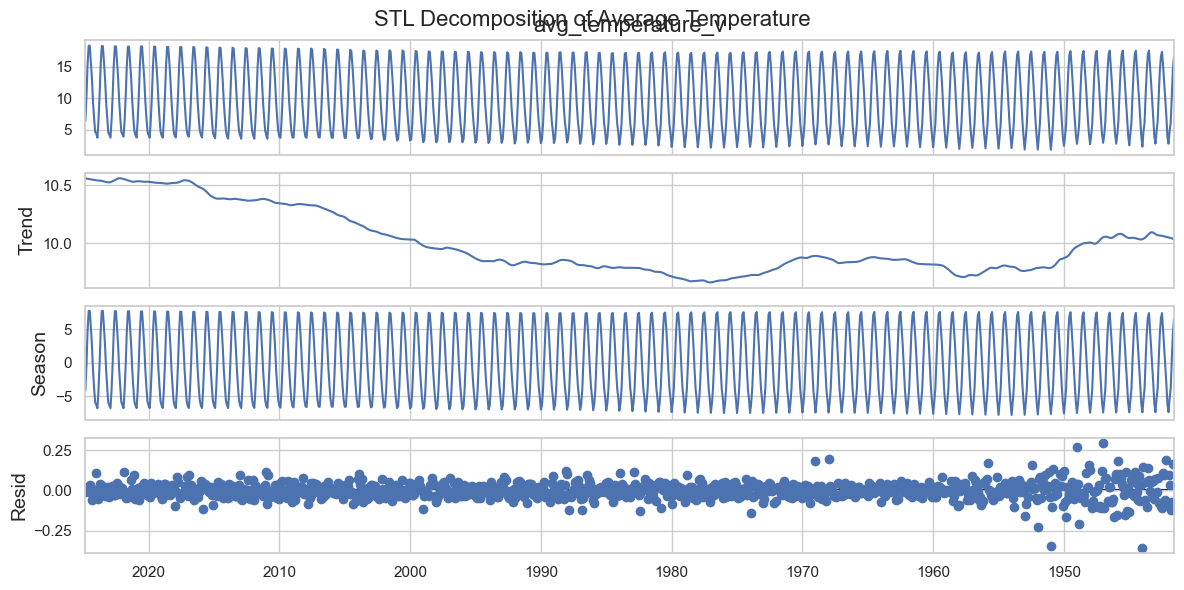

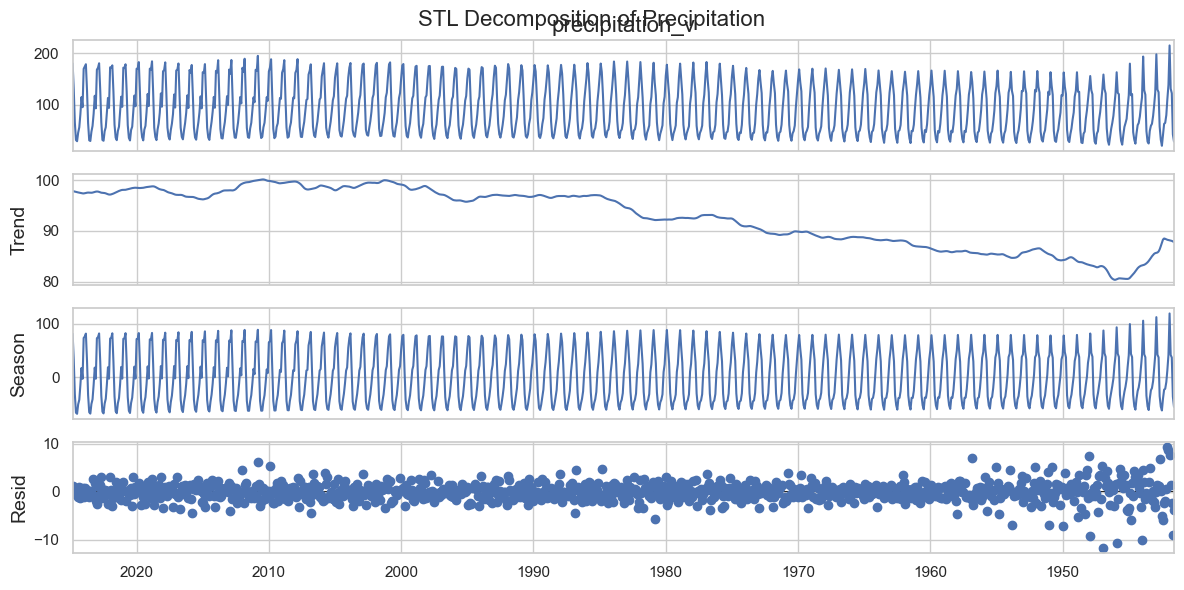

In [112]:
from statsmodels.tsa.seasonal import STL

# Decompose average temperature with STL
stl_temp = STL(cleaned_data['avg_temperature_v'], seasonal=13).fit()
stl_temp.plot()
plt.suptitle("STL Decomposition of Average Temperature", fontsize=16)
plt.show()

# Decompose precipitation with STL
stl_precip = STL(cleaned_data['precipitation_v'], seasonal=13).fit()
stl_precip.plot()
plt.suptitle("STL Decomposition of Precipitation", fontsize=16)
plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2024-11-01 to 1941-08-01
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   max_dew_point_v          851 non-null    float64
 1   max_dew_point_s          851 non-null    float64
 2   max_dew_point_c          851 non-null    float64
 3   max_dew_point_d          851 non-null    object 
 4   max_relative_humidity_v  851 non-null    float64
 5   max_relative_humidity_s  851 non-null    float64
 6   max_relative_humidity_c  851 non-null    float64
 7   max_relative_humidity_d  851 non-null    object 
 8   max_temperature_v        1000 non-null   float64
 9   max_temperature_s        1000 non-null   float64
 10  max_temperature_c        1000 non-null   int64  
 11  max_temperature_d        1000 non-null   object 
 12  max_wind_speed_v         851 non-null    float64
 13  max_wind_speed_s         851 non-null    float64
 14  max_wi

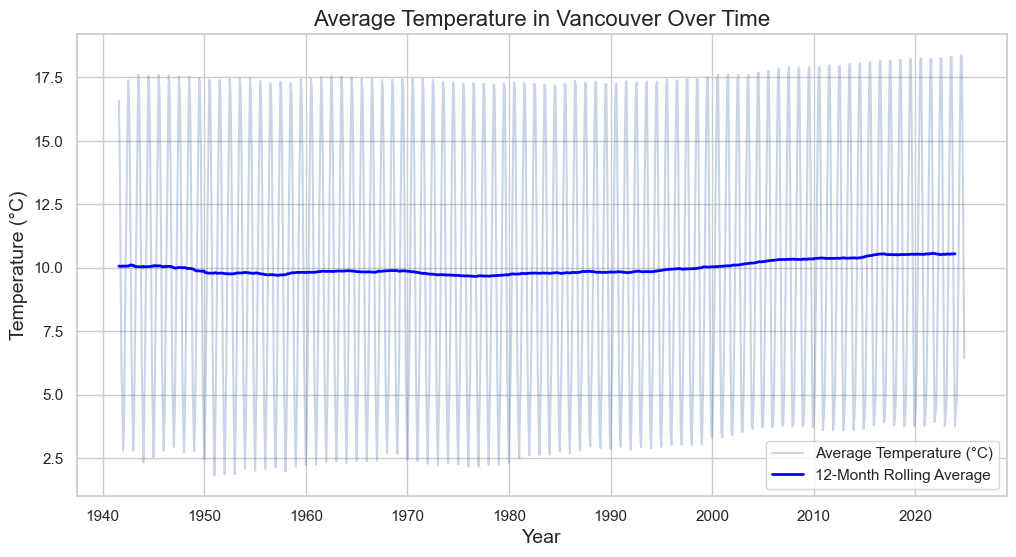

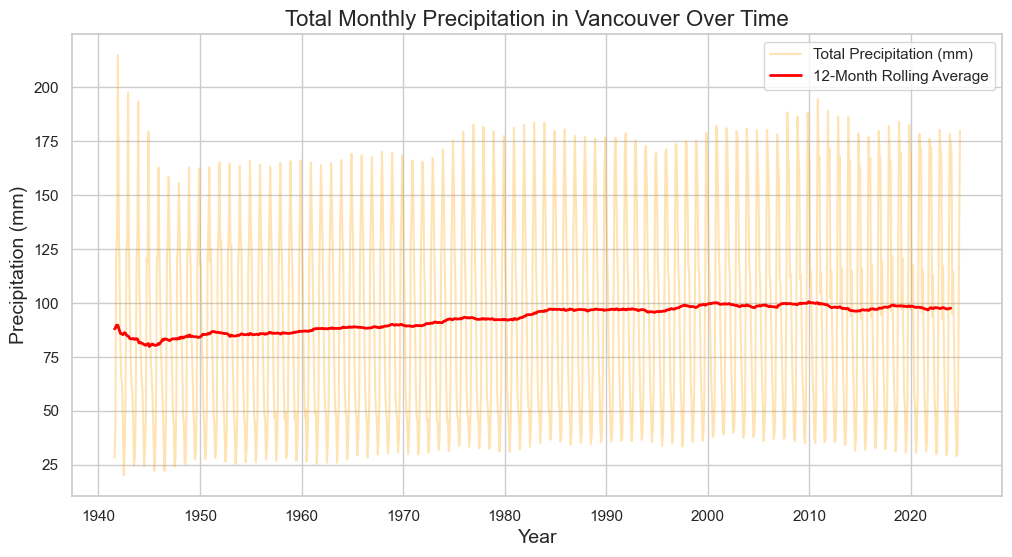